In [ ]:
!pip install torch torchvision albumentations opencv-python matplotlib

In [ ]:
import os
import random
import math
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import cv2
import matplotlib.pyplot as plt

# Cấu hình hiển thị matplotlib
plt.rcParams['figure.figsize'] = (6, 4)

# ======================
# HÀM CÀI ĐẶT SEED NGẪU NHIÊN
# ======================
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ======================
# KIỂM TRA THIẾT BỊ (GPU/NPU/CPU)
# ======================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ======================
# HÀM HIỂN THỊ ẢNH
# ======================
def imshow(img, title=None):
    if torch.is_tensor(img):
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(np.clip(img, 0, 1))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.11.3 which is incompatible.
tensorflow-intel 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.5.3 which is incompatible.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 6.32.1 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.20.0 which is incompatible.


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 3.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.5 MB/s  0:00:00

  Attempting uninstall: typing-extensions

    Found existing installation: typing_extensions 4.12.2

    Uninstalling typing_extensions-4.12.2:

   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- ----------------------------------- 1/9 [typing-extensions]
   ---- -------

In [ ]:
  # ======================
  # TẢI VÀ CHUẨN BỊ DỮ LIỆU OXFORD-IIIT PET
  # ======================
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import random
import os

# ----------------------
# ĐƯỜNG DẪN DỮ LIỆU
# ----------------------
root = "./data/pets"
os.makedirs(root, exist_ok=True)

# ----------------------
# BIẾN ĐỔI ẢNH & MASK
# ----------------------
tfm_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

tfm_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),  # giữ mask dạng [1,H,W] với giá trị class-id
])

# ----------------------
# CUSTOM DATASET
# ----------------------
class PetSeg(Dataset):
    def __init__(self, train=True):
        split = 'trainval' if train else 'test'
        self.base = OxfordIIITPet(
            root=root,
            split=split,
            target_types='segmentation',
            download=True
        )

        # Tách train/test đơn giản (85% train, 15% val)
        n = len(self.base)
        idx = list(range(n))
        random.seed(0)
        random.shuffle(idx)
        cut = int(0.85 * n)
        self.ids = idx[:cut] if train else idx[cut:]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        img, mask = self.base[self.ids[i]]

        # Biến đổi ảnh và mask
        img = tfm_img(img)
        m = tfm_mask(mask).squeeze(0)  # [H,W]

        # mask có giá trị {1, 2, 3}: background/border/object
        # Chuẩn hóa về nhị phân {0, 1}
        m = (m > 1).long()  # object (>1) là 1, còn lại 0

        return img, m

# ----------------------
# TẠO DATASET VÀ DATALOADER
# ----------------------
train_ds = PetSeg(train=True)
val_ds = PetSeg(train=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False,
                        num_workers=0, pin_memory=True)

# ----------------------
# KIỂM TRA MỘT BATCH
# ----------------------
imgs, msks = next(iter(train_loader))
print("Batch:", imgs.shape, msks.shape, msks.unique())


100%|██████████| 792M/792M [03:31<00:00, 3.74MB/s]  
100%|██████████| 19.2M/19.2M [00:06<00:00, 3.16MB/s]
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256]) tensor([0, 1])


In [ ]:
class TinyFCN(nn.Module)                          :
    def   __init__(self, in_ch=3, mid=32, n_classes=2):
        super().__init__()

        # ----------------------
        # ENCODER (trích đặc trưng)
        # ----------------------
        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, mid, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # giảm 1/2 kích thước (H/2, W/2)
            nn.Conv2d(mid, 2 * mid, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)           # giảm 1/4 kích thước (H/4, W/4)
        )

        # ----------------------
        # DECODER (phục hồi kích thước)
        # ----------------------
        self.decoder = nn.Sequential(
            nn.Conv2d(2 * mid, mid, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, n_classes, 1)  # không dùng padding ở đây
        )

    def forward(self, x):
        H, W = x.shape[-2:]  # Lưu lại kích thước gốc
        f = self.encoder(x)  # [B, 2*mid, H/4, W/4]
        logits = self.decoder(f)  # [B, C, H/4, W/4]
        logits = F.interpolate(logits, size=(H, W),
                               mode='bilinear', align_corners=False)
        return logits

# ======================
# KHỞI TẠO MÔ HÌNH
# ======================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_fcn = TinyFCN().to(device)

print(model_fcn)

TinyFCN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [ ]:
def dice_loss(logits, targets, eps=1e-6):
    """
    Tính Dice Loss giữa dự đoán và ground truth.
    ----------
    logits: torch.Tensor [B, C, H, W]
        Đầu ra của mạng (chưa qua softmax).
    targets: torch.Tensor [B, H, W]
        Nhãn nhị phân (giá trị 0 hoặc 1).
    eps: float
        Hằng số nhỏ để tránh chia cho 0.
    ----------
    Trả về:
        Dice loss (float)
    """
      # Xác suất lớp positive (lớp 1)
    probs = torch.softmax(logits, dim=1)[:, 1]  # [B, H, W]
    tgt = (targets == 1).float()

    # Giao & hợp
    inter = (probs * tgt).sum()
    union = probs.sum() + tgt.sum()

    # Dice coefficient & Dice loss
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice


# ======================
# HÀM TÍNH MIOU (CHO SEGMENTATION NHỊ PHÂN)
# ======================
@torch.no_grad()
def miou_binary(logits, targets):
    """
    Tính mean Intersection over Union (mIoU) cho segmentation nhị phân.
    ----------
    logits : torch.Tensor [B, C, H, W]
    targets : torch.Tensor [B, H, W]
    ----------
    Trả về:
        mIoU (float)
    """
    # Dự đoán nhị phân: chọn lớp 1 nếu softmax > 0.5
    pred = (torch.softmax(logits, dim=1)[:, 1] > 0.5).long()
    tgt = (targets == 1).long()

    inter = (pred * tgt).sum().item()
    union = ((pred + tgt) > 0).sum().item()

    return inter / union if union > 0 else 0.0

In [ ]:
  # ======================
  # 1️⃣ HÀM HUẤN LUYỆN 1 EPOCH
  # ======================
def train_one_epoch(model, loader, opt):
    model.train()
    loss_sum = 0.0

    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)

        # Dự đoán
        logits = model(img)

        # Kết hợp CrossEntropy + Dice Loss
        loss = F.cross_entropy(logits, msk) + dice_loss(logits, msk)

        # Lan truyền ngược & cập nhật trọng số
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Cộng dồn loss (theo số lượng mẫu)
        loss_sum += loss.item() * img.size(0)

    # Trả về loss trung bình trên toàn dataset
    return loss_sum / len(loader.dataset)


# ======================
# 2️⃣ HÀM ĐÁNH GIÁ (VALIDATION)
# ======================
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    miou = []

    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)
        logits = model(img)
        miou.append(miou_binary(logits, msk))

    return float(np.mean(miou))


# ======================
# 3️⃣ KHỞI TẠO OPTIMIZER VÀ HUẤN LUYỆN
# ======================
opt = torch.optim.Adam(model_fcn.parameters(), lr=1e-3)

for epoch in range(5):
    tr_loss = train_one_epoch(model_fcn, train_loader, opt)
    val_miou = evaluate(model_fcn, val_loader)
    print(f"Epoch {epoch+1}: loss={tr_loss:.4f}, mIoU={val_miou:.4f}")

Epoch 1: loss=0.8241, mIoU=0.6996
Epoch 2: loss=0.7648, mIoU=0.7045
Epoch 3: loss=0.7239, mIoU=0.7360
Epoch 4: loss=0.6779, mIoU=0.7255
Epoch 5: loss=0.6403, mIoU=0.7498


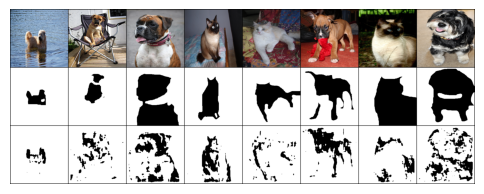

In [ ]:
@torch.no_grad()
def viz_batch(model, loader):
    model.eval()
    imgs, msks = next(iter(loader))
    imgs = imgs.to(device)
    logits = model(imgs)

    # Dự đoán mask nhị phân
    preds = (torch.softmax(logits, dim=1)[:, 1].cpu() > 0.5).float().unsqueeze(1)  # [B,1,H,W]

    # Khôi phục ảnh từ normalize (chuyển về CPU luôn)
    imgs_vis = imgs.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    imgs_vis = imgs_vis.clamp(0,1)

    # Đưa mask (1 kênh) → 3 kênh để ghép được với ảnh RGB
    msks_rgb = msks.unsqueeze(1).repeat(1,3,1,1).float()
    preds_rgb = preds.repeat(1,3,1,1)

    # Ghép ảnh, mask thật, mask dự đoán theo batch
    grid = torch.cat([imgs_vis, msks_rgb, preds_rgb], dim=0)

    # Hiển thị
    imshow(make_grid(grid, nrow=imgs.size(0)))


# Gọi hàm hiển thị
viz_batch(model_fcn, val_loader)

Device: cpu
Found categories (id:count): [(0, 100), (1, 100), (2, 100), (3, 100), (4, 100), (5, 100), (6, 100), (7, 96), (8, 100), (9, 100)] ... total categories: 37
Selected category id: 0
[tinyv2_cat0_binary_ce_dice] Epoch 1/8 loss=1.3340 mean_mIoU=0.4364 per_class=[0.872 0.001]
[tinyv2_cat0_binary_ce_dice] Epoch 2/8 loss=1.0785 mean_mIoU=0.5182 per_class=[0.829 0.207]
[tinyv2_cat0_binary_ce_dice] Epoch 3/8 loss=0.9460 mean_mIoU=0.5284 per_class=[0.801 0.256]
[tinyv2_cat0_binary_ce_dice] Epoch 4/8 loss=0.8651 mean_mIoU=0.5329 per_class=[0.81  0.255]
[tinyv2_cat0_binary_ce_dice] Epoch 5/8 loss=0.8037 mean_mIoU=0.5629 per_class=[0.865 0.261]
[tinyv2_cat0_binary_ce_dice] Epoch 6/8 loss=0.7523 mean_mIoU=0.5629 per_class=[0.869 0.256]
[tinyv2_cat0_binary_ce_dice] Epoch 7/8 loss=0.7304 mean_mIoU=0.5630 per_class=[0.862 0.264]
[tinyv2_cat0_binary_ce_dice] Epoch 8/8 loss=0.6956 mean_mIoU=0.5675 per_class=[0.854 0.281]


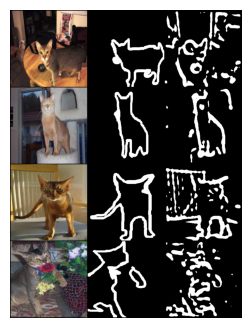

[tinyv2_cat0_multi_ce_dice] Epoch 1/8 loss=1.6182 mean_mIoU=0.2988 per_class=[0.303 0.593 0.   ]
[tinyv2_cat0_multi_ce_dice] Epoch 2/8 loss=1.3582 mean_mIoU=0.3250 per_class=[0.423 0.506 0.046]
[tinyv2_cat0_multi_ce_dice] Epoch 3/8 loss=1.3098 mean_mIoU=0.3751 per_class=[0.39  0.608 0.127]
[tinyv2_cat0_multi_ce_dice] Epoch 4/8 loss=1.2136 mean_mIoU=0.4193 per_class=[0.457 0.609 0.192]
[tinyv2_cat0_multi_ce_dice] Epoch 5/8 loss=1.1304 mean_mIoU=0.4416 per_class=[0.417 0.653 0.254]
[tinyv2_cat0_multi_ce_dice] Epoch 6/8 loss=1.0910 mean_mIoU=0.4707 per_class=[0.441 0.677 0.294]
[tinyv2_cat0_multi_ce_dice] Epoch 7/8 loss=1.0886 mean_mIoU=0.4611 per_class=[0.485 0.61  0.287]
[tinyv2_cat0_multi_ce_dice] Epoch 8/8 loss=1.0568 mean_mIoU=0.4905 per_class=[0.496 0.669 0.307]


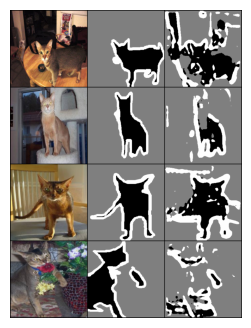

[tiny_ce_cat0] Epoch 1/6 loss=0.4944 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_ce_cat0] Epoch 2/6 loss=0.4212 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_ce_cat0] Epoch 3/6 loss=0.4099 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_ce_cat0] Epoch 4/6 loss=0.4028 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_ce_cat0] Epoch 5/6 loss=0.3991 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_ce_cat0] Epoch 6/6 loss=0.3941 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_focal_cat0] Epoch 1/6 loss=0.1524 mean_mIoU=0.4338 per_class=[0.867 0.   ]
[tiny_focal_cat0] Epoch 2/6 loss=0.1200 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_focal_cat0] Epoch 3/6 loss=0.1124 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_focal_cat0] Epoch 4/6 loss=0.1098 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_focal_cat0] Epoch 5/6 loss=0.1074 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_focal_cat0] Epoch 6/6 loss=0.1058 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tiny_lovasz_cat0] Epoch 1/6 loss=0.5060 mean_

In [ ]:
  # full_fcn_experiments.py
  # Chạy được trong Notebook / script (đảm bảo đã cài các package: torch, torchvision, albumentations, matplotlib, opencv-python)

import os, random, json, time
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

  # -----------------------
  # CẤU HÌNH CHUNG
  # -----------------------
SEED = 42
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

EXPT_DIR = Path("./fcn_experiments")
EXPT_DIR.mkdir(parents=True, exist_ok=True)
(EXPT_DIR / "checkpoints").mkdir(exist_ok=True)

# -----------------------
# DATA TRANSFORMS & DATASET (có trả về 'segmentation' và 'category')
# -----------------------
root = "./data/pets"
os.makedirs(root, exist_ok=True)

tfm_img = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
tfm_mask = transforms.Compose([
    transforms.Resize((256,256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),  # [1,H,W]
])

class PetSegFull(Dataset):
    """
    Trả về:
      img: Tensor [3,H,W]
      mask: Tensor [H,W] (class ids)  --> note: original values {1,2,3} for segmentation
      label: int  (category index)    --> 0..N-1
    """
    def __init__(self, root, split='trainval', download=True, only_classes=None):
        # only_classes: list of category ids to keep (int) OR None to keep all
        self.base = OxfordIIITPet(root=root, split=split,
                                  target_types=('segmentation','category'),
                                  download=download)
        # self.base[i] returns (PIL img, (mask_pil, category_idx))
        self.ids = list(range(len(self.base)))
        # Optionally filter by category ids
        if only_classes is not None:
            allowed = set(only_classes)
            new_ids = []
            for i in self.ids:
                _, (mask, cat) = self.base[i]
                if int(cat) in allowed:
                    new_ids.append(i)
            self.ids = new_ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img, (mask, cat) = self.base[self.ids[idx]]
        img = tfm_img(img)
        m = tfm_mask(mask).squeeze(0)  # [H,W]
        # In dataset, mask values are 1..3: 1 background, 2 border, 3 object
        # To convert to multiclass segmentation labels (e.g. 0..K-1), here we keep:
        # map: 1 -> 0 (background), 2 -> 1 (border), 3 -> 2 (object)
        m = (m - 1).long()  # now {0,1,2}
        # We will treat object class (2 -> now 2) as the "thing" class; for binary tasks we will collapse.
        return img, m, int(cat)

# -----------------------
# Helper: build filtered dataset for one class (category)
# -----------------------
def build_dataloaders(target_classes=None, batch_size=8, shuffle=True):
    """
    target_classes: None (all categories) or list of category ids (ints) to keep
    Returns train_loader, val_loader, class_map (not used)
    """
    train_ds = PetSegFull(root, split='trainval', download=True, only_classes=target_classes)
    val_ds = PetSegFull(root, split='test', download=True, only_classes=target_classes)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_loader, val_loader, train_ds, val_ds

# -----------------------
# MODELS
# - TinyFCN (original)
# - TinyFCNv2 (with BatchNorm + extra convs)
# Both support variable n_classes
# -----------------------
class TinyFCN(nn.Module):
    def __init__(self, in_ch=3, mid=32, n_classes=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, mid, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # /2
            nn.Conv2d(mid, 2*mid, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # /4
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(2*mid, mid, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(mid, n_classes, 1)
        )
    def forward(self, x):
        H, W = x.shape[-2:]
        f = self.encoder(x)
        logits = self.decoder(f)
        logits = F.interpolate(logits, size=(H,W), mode='bilinear', align_corners=False)
        return logits

class TinyFCNv2(nn.Module):
    """
    Mô hình mở rộng: nhiều conv hơn + BatchNorm
    """
    def __init__(self, in_ch=3, mid=32, n_classes=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
            nn.Conv2d(2*mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(2*mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
            nn.Conv2d(2*mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, n_classes, 1)
        )
    def forward(self, x):
        H, W = x.shape[-2:]
        f = self.encoder(x)
        logits = self.decoder(f)
        logits = F.interpolate(logits, size=(H,W), mode='bilinear', align_corners=False)
        return logits

# -----------------------
# LOSSES: Dice, Focal, Lovasz (Lovasz softmax impl)
# -----------------------
def dice_loss(logits, targets, eps=1e-6):
    # logits: [B,C,H,W], targets: [B,H,W] with values 0..C-1
    C = logits.shape[1]
    probs = torch.softmax(logits, dim=1)
    # compute dice per class then average (except maybe background if desired)
    dice_per_class = []
    for c in range(C):
        p = probs[:,c]
        t = (targets==c).float()
        inter = (p * t).sum()
        union = p.sum() + t.sum()
        dice = (2*inter + eps) / (union + eps)
        dice_per_class.append(dice)
    # average dice across classes
    mean_dice = torch.stack(dice_per_class).mean()
    return 1 - mean_dice

# Focal Loss (multi-class)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
    def forward(self, logits, targets):
        # logits: [B,C,H,W], targets: [B,H,W]
        C = logits.shape[1]
        logpt = -F.cross_entropy(logits, targets, reduction='none')  # negative of CE per element
        pt = torch.exp(logpt)
        loss = ((1-pt)**self.gamma * (-logpt))
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Lovasz-Softmax implementation for multiclass
# Reference logic adapted from common public implementations (lovasz_softmax).
# Implementation below is a concise variant for CPU/GPU usage.
def lovasz_grad(gt_sorted):
    gts = gt_sorted.sum()
    if gts == 0:
        return gt_sorted*0
    intersection = gts - gt_sorted.cumsum(0)
    union = gts + (1 - gt_sorted).cumsum(0)
    jaccard = 1. - intersection / union
    if gt_sorted.numel() > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

def lovasz_softmax_flat(probs, labels, ignore_index=None):
    """
    probs: [P, C] probabilities (softmaxed) for P pixels
    labels: [P] ground truth labels 0..C-1
    """
    C = probs.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float()
        if ignore_index is not None:
            fg[labels==ignore_index] = 0
        if fg.sum() == 0:
            continue
        class_pred = probs[:, c]
        errors = (fg - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        grad = lovasz_grad(fg_sorted)
        losses.append((errors_sorted * grad).sum())
    if len(losses) == 0:
        return torch.tensor(0., device=probs.device)
    return torch.stack(losses).mean()

def lovasz_softmax(logits, labels, ignore_index=None):
    """
    logits: [B,C,H,W], labels: [B,H,W]
    """
    C = logits.shape[1]
    probs = torch.softmax(logits, dim=1)
    probs_flat = probs.permute(0,2,3,1).reshape(-1, C)
    labels_flat = labels.view(-1)
    if ignore_index is not None:
        mask = (labels_flat != ignore_index)
        probs_flat = probs_flat[mask]
        labels_flat = labels_flat[mask]
    return lovasz_softmax_flat(probs_flat, labels_flat, ignore_index=ignore_index)

# -----------------------
# METRICS: IoU per class & mean IoU
# -----------------------
@torch.no_grad()
def iou_per_class(logits, targets, n_classes):
    # return list of IoU for each class (0..n_classes-1)
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)  # [B,H,W]
    ious = []
    for c in range(n_classes):
        pred_c = (preds == c)
        true_c = (targets == c)
        inter = (pred_c & true_c).sum().item()
        union = (pred_c | true_c).sum().item()
        ious.append(inter/union if union>0 else 0.0)
    return ious

@torch.no_grad()
def mean_iou_dataset(model, loader, n_classes):
    model.eval()
    sums = np.zeros(n_classes, dtype=np.float64)
    counts = np.zeros(n_classes, dtype=np.int64)
    for img, mask, _ in loader:
        img = img.to(device)
        logits = model(img)
        ious = iou_per_class(logits.cpu(), mask, n_classes)
        sums += np.array(ious)
        counts += 1
    return (sums / (counts + 1e-12)).tolist()

# -----------------------
# SAVE / LOAD checkpoint
# -----------------------
def save_checkpoint(model, opt, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'opt_state': opt.state_dict()
    }, path)

def load_checkpoint(model, path, device=device):
    ck = torch.load(path, map_location=device)
    model.load_state_dict(ck['model_state'])
    return ck

# -----------------------
# TRAIN LOOP (flexible: choose model, loss_type)
# -----------------------
def train_and_eval(model, train_loader, val_loader, n_classes,
                   loss_type='ce_dice', lr=1e-3, epochs=10,
                   expt_name="run", save_best=True):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_miou = -1
    history = {'train_loss': [], 'val_miou': []}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        n_samples = 0
        for img, mask, _ in train_loader:
            img = img.to(device); mask = mask.to(device)
            logits = model(img)
            if loss_type == 'ce':
                loss = F.cross_entropy(logits, mask)
            elif loss_type == 'dice':
                loss = dice_loss(logits, mask)
            elif loss_type == 'ce_dice':
                loss = F.cross_entropy(logits, mask) + dice_loss(logits, mask)
            elif loss_type == 'focal':
                fl = FocalLoss(gamma=2.0)
                loss = fl(logits, mask)
            elif loss_type == 'lovasz':
                loss = lovasz_softmax(logits, mask)
            else:
                raise ValueError("unknown loss_type")
            opt.zero_grad()
            loss.backward()
            opt.step()
            bs = img.size(0)
            running_loss += loss.item() * bs
            n_samples += bs
        avg_loss = running_loss / (n_samples + 1e-12)
        # eval
        val_mious = mean_iou_dataset(model, val_loader, n_classes)
        mean_miou = float(np.mean(val_mious))
        history['train_loss'].append(avg_loss)
        history['val_miou'].append(mean_miou)
        print(f"[{expt_name}] Epoch {epoch}/{epochs} loss={avg_loss:.4f} mean_mIoU={mean_miou:.4f} per_class={np.round(val_mious,3)}")
        # save best
        if save_best and mean_miou > best_miou:
            best_miou = mean_miou
            ck_path = EXPT_DIR / "checkpoints" / f"{expt_name}_best.pth"
            save_checkpoint(model, opt, epoch, ck_path)
    # final save of history
    with open(EXPT_DIR / f"{expt_name}_history.json", "w") as f:
        json.dump(history, f)
    return history

# -----------------------
# VISUALIZE UTILS
# -----------------------
def imshow(img, title=None):
    if torch.is_tensor(img):
        img = img.detach().cpu().numpy().transpose(1,2,0)
    plt.imshow(np.clip(img,0,1))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

@torch.no_grad()
def viz_examples(model, loader, n=4):
    model.eval()
    imgs, masks, _ = next(iter(loader))
    imgs_gpu = imgs.to(device)
    logits = model(imgs_gpu)
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1).cpu()  # [B,H,W]
    # prepare visualization grid: for first n images show rgb, gt, pred
    imgs_vis = (imgs * torch.tensor([0.229,0.224,0.225]).view(3,1,1) +
                torch.tensor([0.485,0.456,0.406]).view(3,1,1)).clamp(0,1)
    to_show = []
    for i in range(min(n, imgs.shape[0])):
        to_show.append(imgs_vis[i])
        # convert mask to 3-channel RGB for visualization by using normalized palette
        gt = masks[i].unsqueeze(0).repeat(3,1,1).float() / (masks[i].max().item()+1e-6)
        pr = preds[i].unsqueeze(0).repeat(3,1,1).float() / (preds[i].max().item()+1e-6 if preds[i].max()>0 else 1)
        to_show.append(gt)
        to_show.append(pr)
    grid = make_grid(torch.stack(to_show), nrow=3)
    imshow(grid)

# -----------------------
# RUN EXPERIMENTS
# Example experiments:
# 1) Train TinyFCN on single category (binary segmentation via collapsing classes -> map all object classes to single positive)
# 2) Train TinyFCNv2 for multi-class (3 classes kept)
# 3) Compare loss functions on same model/dataset
# -----------------------
def collapse_to_binary_dataset(ds):
    # wrap a dataset to convert mask {0,1,2} -> {0,1} where object class (2) -> 1, else 0
    class Wrap(Dataset):
        def __init__(self, ds):
            self.ds = ds
        def __len__(self): return len(self.ds)
        def __getitem__(self, i):
            img, m, cat = self.ds[i]
            # object class was 2 (as we set earlier), convert to binary
            m_bin = (m == 2).long()
            return img, m_bin, cat
    return Wrap(ds)

# ---------- Example 1: train on single category (binary)
# Find category ids: load dataset and inspect categories -> OxfordIIITPet provides category indices from 0..36
base_all = OxfordIIITPet(root=root, split='trainval', target_types=('segmentation','category'), download=False)
# To list categories and counts:
cats = {}
for i in range(len(base_all)):
    _, (mask, cat) = base_all[i]
    cats[int(cat)] = cats.get(int(cat), 0) + 1
print("Found categories (id:count):", list(cats.items())[:10], "... total categories:", len(cats))

# Choose one category id (example: the most frequent or first key)
target_cat_id = list(cats.keys())[0]
print("Selected category id:", target_cat_id)

# Build dataloaders containing only that category
train_loader, val_loader, train_ds, val_ds = build_dataloaders(target_classes=[target_cat_id], batch_size=8)

# For binary training, wrap datasets to collapse classes to binary
train_bin = collapse_to_binary_dataset(train_ds)
val_bin = collapse_to_binary_dataset(val_ds)
train_loader_bin = DataLoader(train_bin, batch_size=8, shuffle=True, num_workers=0)
val_loader_bin = DataLoader(val_bin, batch_size=8, shuffle=False, num_workers=0)

# Model (binary: n_classes=2)
model_bin = TinyFCNv2(in_ch=3, mid=32, n_classes=2).to(device)
# Train with CE + Dice (baseline)
hist1 = train_and_eval(model_bin, train_loader_bin, val_loader_bin, n_classes=2,
                      loss_type='ce_dice', lr=1e-3, epochs=8, expt_name=f"tinyv2_cat{target_cat_id}_binary_ce_dice")

# visualize examples
viz_examples(model_bin, val_loader_bin)

# ---------- Example 2: multiclass training (keep all 3 segmentation labels -> n_classes=3)
train_loader_m, val_loader_m, train_dsm, val_dsm = build_dataloaders(target_classes=[target_cat_id], batch_size=8)
# These ds already return masks with values {0,1,2}
model_multi = TinyFCNv2(in_ch=3, mid=32, n_classes=3).to(device)
hist_multi = train_and_eval(model_multi, train_loader_m, val_loader_m, n_classes=3,
                            loss_type='ce_dice', lr=1e-3, epochs=8, expt_name=f"tinyv2_cat{target_cat_id}_multi_ce_dice")
viz_examples(model_multi, val_loader_m)

# ---------- Example 3: compare losses on same model/dataset (binary)
# reload model fresh for fair comparison
model_ce = TinyFCN(in_ch=3, mid=32, n_classes=2).to(device)
_ = train_and_eval(model_ce, train_loader_bin, val_loader_bin, n_classes=2,
                   loss_type='ce', lr=1e-3, epochs=6, expt_name=f"tiny_ce_cat{target_cat_id}")

model_focal = TinyFCN(in_ch=3, mid=32, n_classes=2).to(device)
_ = train_and_eval(model_focal, train_loader_bin, val_loader_bin, n_classes=2,
                   loss_type='focal', lr=1e-3, epochs=6, expt_name=f"tiny_focal_cat{target_cat_id}")

model_lov = TinyFCN(in_ch=3, mid=32, n_classes=2).to(device)
_ = train_and_eval(model_lov, train_loader_bin, val_loader_bin, n_classes=2,
                   loss_type='lovasz', lr=1e-3, epochs=6, expt_name=f"tiny_lovasz_cat{target_cat_id}")

print("Experiments finished. Checkpoints & histories saved under:", EXPT_DIR)


Loaded checkpoint epoch 8
mIoU after loading: [0.8535388561631198, 0.28136140267316784]


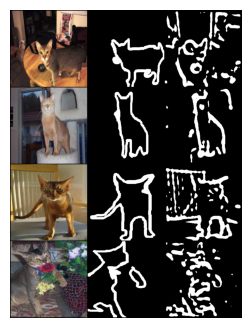

In [ ]:
  # --- load and evaluate example ---
ck_path = EXPT_DIR / "checkpoints" / f"tinyv2_cat{target_cat_id}_binary_ce_dice_best.pth"
if ck_path.exists():
    ck = load_checkpoint(model_bin, ck_path, device=device)   # model_bin must be same arch
    print("Loaded checkpoint epoch", ck.get('epoch'))
    # evaluate loaded model on validation
    val_mious_loaded = mean_iou_dataset(model_bin, val_loader_bin, n_classes=2)
    print("mIoU after loading:", val_mious_loaded)
    viz_examples(model_bin, val_loader_bin, n=4)
else:
    print("Checkpoint not found:", ck_path)


In [ ]:
def resume_train_from_checkpoint(model, ck_path, train_loader, val_loader, n_classes, lr=1e-3, epochs=5, expt_name="resume"):
    # load checkpoint (includes opt_state if saved)
    ck = torch.load(ck_path, map_location=device)
    model.load_state_dict(ck['model_state'])
    start_epoch = ck.get('epoch', 0) + 1

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    if 'opt_state' in ck:
        try:
            opt.load_state_dict(ck['opt_state'])
            print("Optimizer state restored.")
        except Exception as e:
            print("Không thể khôi phục optimizer state:", e)

    # continue training (simple loop)
    best_miou = -1
    for epoch in range(start_epoch, start_epoch + epochs):
        # a simple single-epoch training wrapper (reuse your train_and_eval or inline)
        _ = train_and_eval(model, train_loader, val_loader, n_classes,
                           loss_type='ce_dice', lr=lr, epochs=1,
                           expt_name=f"{expt_name}_cont_epoch{epoch}", save_best=True)
    return model

# Example usage:
# model_bin = TinyFCNv2(...).to(device)
# resume_train_from_checkpoint(model_bin, ck_path, train_loader_bin, val_loader_bin, n_classes=2, epochs=3)


In [ ]:
  # Build map name -> id from base_all dataset
def build_name_to_id_map(root):
    base = OxfordIIITPet(root=root, split='trainval', target_types=('segmentation','category'), download=False)
    name2id = {}
    for i in range(len(base)):
        _, (mask, cat) = base[i]
        # base has _get_metadata? if not, we can infer name via filenames but torchvision gives category index only
        # Here we collect ids (unique)
        name2id.setdefault(int(cat), 0)
        name2id[int(cat)] += 1
    # This returns counts keyed by id; torchvision API doesn't provide text names directly.
    return name2id

# Nếu bạn muốn chọn theo "tên" (ví dụ 'Abyssinian'), cần thêm mapping tên ↔ file list,
# ví dụ: parse Oxford-IIITPet file names under root to map textual class names to indices.
print("Category counts (id:count):", build_name_to_id_map(root))


Category counts (id:count): {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 96, 8: 100, 9: 100, 10: 100, 11: 93, 12: 96, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 96, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 30: 100, 31: 100, 32: 99, 33: 100, 34: 100, 35: 100, 36: 100}


Saved summary to fcn_experiments\experiments_summary.csv


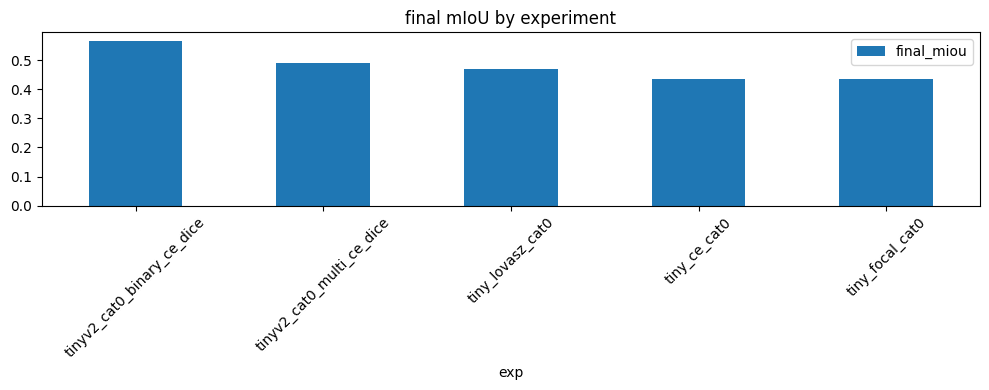

In [ ]:
import pandas as pd
def collect_and_plot_histories(expt_dir=EXPT_DIR):
    # load all *_history.json files
    rows = []
    for p in expt_dir.glob("*_history.json"):
        with open(p,'r') as f:
            h = json.load(f)
        name = p.stem.replace("_history","")
        # take final values
        rows.append({'exp': name, 'final_loss': h['train_loss'][-1] if h['train_loss'] else None,
                     'final_miou': h['val_miou'][-1] if h['val_miou'] else None,
                     'history': h})
    df = pd.DataFrame(rows)
    csv_path = expt_dir / "experiments_summary.csv"
    df.to_csv(csv_path, index=False)
    print("Saved summary to", csv_path)
    # quick plot
    try:
        df_plot = df.dropna(subset=['final_miou']).sort_values('final_miou', ascending=False)
        df_plot.plot.bar(x='exp', y='final_miou', rot=45, figsize=(10,4), title='final mIoU by experiment')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Plot failed:", e)
    return df
df_summary = collect_and_plot_histories(EXPT_DIR)


Available category ids (id:count) - choose one id for TARGET_CAT_ID:
[(0, 100), (1, 100), (2, 100), (3, 100), (4, 100), (5, 100), (6, 100), (7, 96), (8, 100), (9, 100), (10, 100), (11, 93), (12, 96), (13, 100), (14, 100), (15, 100), (16, 100), (17, 100), (18, 100), (19, 100)] ... total categories: 37
Using TARGET_CAT_ID = 0


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[tinyv3_cat0_binary_ce_dice] Epoch 1/6 loss=1.0120 mean_mIoU=0.4362 per_class=[0.872 0.   ]
[tinyv3_cat0_binary_ce_dice] Epoch 2/6 loss=0.8501 mean_mIoU=0.5239 per_class=[0.851 0.197]
[tinyv3_cat0_binary_ce_dice] Epoch 3/6 loss=0.7681 mean_mIoU=0.5425 per_class=[0.84  0.245]
[tinyv3_cat0_binary_ce_dice] Epoch 4/6 loss=0.7287 mean_mIoU=0.5197 per_class=[0.878 0.161]
[tinyv3_cat0_binary_ce_dice] Epoch 5/6 loss=0.7016 mean_mIoU=0.5638 per_class=[0.869 0.258]
[tinyv3_cat0_binary_ce_dice] Epoch 6/6 loss=0.6688 mean_mIoU=0.5674 per_class=[0.851 0.283]
Saved checkpoint to fcn_experiments\checkpoints\tinyv3_cat0_binary_ce_dice_final.pth
Loaded model weights from fcn_experiments\checkpoints\tinyv3_cat0_binary_ce_dice_best.pth epoch: 6
Validation mIoU after loading best ck: [0.851457046847877, 0.2833092151286994]


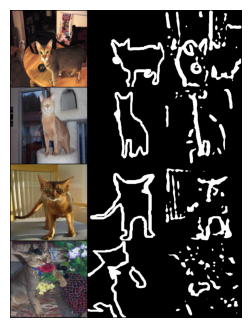

[tinyv3_cat0_multi_ce_dice] Epoch 1/6 loss=1.6247 mean_mIoU=0.3213 per_class=[0.368 0.596 0.   ]
[tinyv3_cat0_multi_ce_dice] Epoch 2/6 loss=1.3242 mean_mIoU=0.3017 per_class=[0.405 0.469 0.031]
[tinyv3_cat0_multi_ce_dice] Epoch 3/6 loss=1.2248 mean_mIoU=0.4376 per_class=[0.428 0.652 0.232]
[tinyv3_cat0_multi_ce_dice] Epoch 4/6 loss=1.2221 mean_mIoU=0.4393 per_class=[0.474 0.594 0.249]
[tinyv3_cat0_multi_ce_dice] Epoch 5/6 loss=1.1147 mean_mIoU=0.4535 per_class=[0.467 0.629 0.265]
[tinyv3_cat0_multi_ce_dice] Epoch 6/6 loss=1.1195 mean_mIoU=0.4428 per_class=[0.479 0.645 0.204]


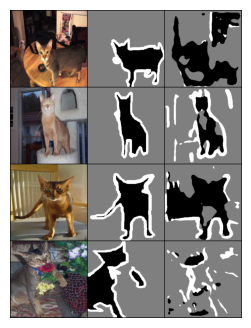

Running experiment: tinyv3_cat0_binary_ce
[tinyv3_cat0_binary_ce] Epoch 1/5 loss=0.6764 mean_mIoU=0.4363 per_class=[0.871 0.002]
[tinyv3_cat0_binary_ce] Epoch 2/5 loss=0.5041 mean_mIoU=0.4666 per_class=[0.866 0.067]
[tinyv3_cat0_binary_ce] Epoch 3/5 loss=0.4375 mean_mIoU=0.5229 per_class=[0.85  0.196]
[tinyv3_cat0_binary_ce] Epoch 4/5 loss=0.3979 mean_mIoU=0.5272 per_class=[0.849 0.205]
[tinyv3_cat0_binary_ce] Epoch 5/5 loss=0.3691 mean_mIoU=0.5157 per_class=[0.869 0.162]
Loaded model weights from fcn_experiments\checkpoints\tinyv3_cat0_binary_ce_best.pth epoch: 4
Running experiment: tinyv3_cat0_binary_ce_dice
[tinyv3_cat0_binary_ce_dice] Epoch 1/5 loss=1.0162 mean_mIoU=0.4390 per_class=[0.873 0.005]
[tinyv3_cat0_binary_ce_dice] Epoch 2/5 loss=0.8656 mean_mIoU=0.5093 per_class=[0.854 0.165]
[tinyv3_cat0_binary_ce_dice] Epoch 3/5 loss=0.7996 mean_mIoU=0.5375 per_class=[0.852 0.223]
[tinyv3_cat0_binary_ce_dice] Epoch 4/5 loss=0.7507 mean_mIoU=0.4883 per_class=[0.76  0.217]
[tinyv3_cat0_b

In [ ]:
  # -----------------------
  # PHẦN BỔ SUNG: LƯU/NẠP, RESUME, MODEL MỚI, GRID EXPERIMENTS, XUẤT CSV/PLOT
  # -----------------------
import pandas as pd
from pathlib import Path

# 1) Hiển thị các category id hiện có (in để bạn chọn)
base_all = OxfordIIITPet(root=root, split='trainval', target_types=('segmentation','category'), download=False)
cats = {}
# cũng in một ví dụ tên file từ dataset để bạn dễ chọn id nếu muốn (nếu torchvision expose filename)
for i in range(len(base_all)):
    _, (mask, cat) = base_all[i]
    cats[int(cat)] = cats.get(int(cat), 0) + 1
print("Available category ids (id:count) - choose one id for TARGET_CAT_ID:")
print(list(cats.items())[:20], "... total categories:", len(cats))

# Set target category id here (chọn một id từ output ở trên)
TARGET_CAT_ID = list(cats.keys())[0]   # <-- bạn có thể đổi số ở đây sang id mong muốn
print("Using TARGET_CAT_ID =", TARGET_CAT_ID)

# 2) Save / Load helper (kèm resume example)
def save_model_state(model, optimizer, epoch, path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'opt_state': optimizer.state_dict()}, path)
    print("Saved checkpoint to", path)

def load_model_state(model, path, device=device, load_opt=False, optimizer=None):
    ck = torch.load(path, map_location=device)
    model.load_state_dict(ck['model_state'])
    print("Loaded model weights from", path, "epoch:", ck.get('epoch'))
    if load_opt and optimizer is not None and 'opt_state' in ck:
        try:
            optimizer.load_state_dict(ck['opt_state'])
            print("Loaded optimizer state")
        except Exception as e:
            print("Cannot load optimizer state:", e)
    return ck

# 3) TinyFCNv3: encoder/decoder mở rộng hơn (thêm conv + BN + skip conv)
class TinyFCNv3(nn.Module):
    def __init__(self, in_ch=3, mid=32, n_classes=2):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
        )  # H,W
        self.pool1 = nn.MaxPool2d(2)  # H/2
        self.enc2 = nn.Sequential(
            nn.Conv2d(mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
            nn.Conv2d(2*mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
        )  # H/2 -> H/4
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(2*mid, 4*mid, 3, padding=1), nn.BatchNorm2d(4*mid), nn.ReLU(inplace=True),
            nn.Conv2d(4*mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
        )
        # decoder with simple upsample + conv blocks
        self.up1 = nn.Sequential(
            nn.Conv2d(2*mid, 2*mid, 3, padding=1), nn.BatchNorm2d(2*mid), nn.ReLU(inplace=True),
            nn.Conv2d(2*mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(inplace=True),
            nn.Conv2d(mid, n_classes, 1)
        )
    def forward(self, x):
        H,W = x.shape[-2:]
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        u1 = F.interpolate(b, scale_factor=2, mode='bilinear', align_corners=False)
        u1 = self.up1(u1)
        # optionally concat skip e2 (but shapes must match); here we will simple add if channels match
        u2 = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        out = self.up2(u2)
        out = F.interpolate(out, size=(H,W), mode='bilinear', align_corners=False)
        return out

# 4) Huấn luyện 1 loại động vật (binary) -> train, save, load, evaluate
train_loader, val_loader, train_ds, val_ds = build_dataloaders(target_classes=[TARGET_CAT_ID], batch_size=8)
train_bin = collapse_to_binary_dataset(train_ds)
val_bin = collapse_to_binary_dataset(val_ds)
train_loader_bin = DataLoader(train_bin, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader_bin = DataLoader(val_bin, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# instantiate model, optimizer
model_bin = TinyFCNv3(in_ch=3, mid=32, n_classes=2).to(device)
opt = torch.optim.Adam(model_bin.parameters(), lr=1e-3)

# train for some epochs (use train_and_eval wrapper which saves best checkpoint)
exp_name = f"tinyv3_cat{TARGET_CAT_ID}_binary_ce_dice"
hist = train_and_eval(model_bin, train_loader_bin, val_loader_bin, n_classes=2,
                      loss_type='ce_dice', lr=1e-3, epochs=6, expt_name=exp_name, save_best=True)

# explicit save final weights & optimizer
final_ck_path = EXPT_DIR / "checkpoints" / f"{exp_name}_final.pth"
save_model_state(model_bin, opt, epoch=len(hist['train_loss']), path=final_ck_path)

# Load back for inference
ck_loaded = EXPT_DIR / "checkpoints" / f"{exp_name}_best.pth"
if ck_loaded.exists():
    _ = load_model_state(model_bin, ck_loaded, device=device, load_opt=False)
    # Evaluate loaded model
    miou_loaded = mean_iou_dataset(model_bin, val_loader_bin, n_classes=2)
    print("Validation mIoU after loading best ck:", miou_loaded)
    viz_examples(model_bin, val_loader_bin, n=4)
else:
    print("Best checkpoint not found:", ck_loaded)

# 5) Multi-class training (retain original 3 classes)
train_loader_m, val_loader_m, train_dsm, val_dsm = build_dataloaders(target_classes=[TARGET_CAT_ID], batch_size=8)
# here masks are {0,1,2}
model_multiclass = TinyFCNv3(in_ch=3, mid=32, n_classes=3).to(device)
hist_multi = train_and_eval(model_multiclass, train_loader_m, val_loader_m, n_classes=3,
                            loss_type='ce_dice', lr=1e-3, epochs=6, expt_name=f"tinyv3_cat{TARGET_CAT_ID}_multi_ce_dice")
viz_examples(model_multiclass, val_loader_m, n=4)

# 6) Grid experiment: compare loss functions on same model architecture (TinyFCNv3) for binary case
losses_to_test = ['ce', 'ce_dice', 'focal', 'lovasz']
grid_results = []
for loss_name in losses_to_test:
    model_g = TinyFCNv3(in_ch=3, mid=32, n_classes=2).to(device)
    expt_name_g = f"tinyv3_cat{TARGET_CAT_ID}_binary_{loss_name}"
    print("Running experiment:", expt_name_g)
    h = train_and_eval(model_g, train_loader_bin, val_loader_bin, n_classes=2,
                       loss_type=loss_name, lr=1e-3, epochs=5, expt_name=expt_name_g, save_best=True)
    # load best ck and compute final miou
    best_ck = EXPT_DIR / "checkpoints" / f"{expt_name_g}_best.pth"
    if best_ck.exists():
        load_model_state(model_g, best_ck, device=device)
        miou_final = mean_iou_dataset(model_g, val_loader_bin, n_classes=2)
    else:
        miou_final = float(np.mean(h['val_miou'])) if h['val_miou'] else None
    grid_results.append({'experiment': expt_name_g, 'loss': loss_name, 'final_mIoU': miou_final, 'history': h})

# Save grid results to CSV/JSON
df = pd.DataFrame([{'experiment': r['experiment'], 'loss': r['loss'], 'final_mIoU': r['final_mIoU']} for r in grid_results])
csv_path = EXPT_DIR / "grid_results.csv"
df.to_csv(csv_path, index=False)
with open(EXPT_DIR / "grid_results.json", "w") as f:
    json.dump(grid_results, f)
print("Saved grid results to", csv_path, "and json")

# Quick bar plot of final mIoU
try:
    df_plot = df.dropna().sort_values('final_mIoU', ascending=False)
    ax = df_plot.plot.bar(x='loss', y='final_mIoU', rot=0, figsize=(8,4), legend=False, ylim=(0,1))
    ax.set_ylabel("final mIoU")
    ax.set_title(f"Loss comparison on cat id {TARGET_CAT_ID}")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot failed:", e)

print("All tasks finished. Checkpoints and logs saved to:", EXPT_DIR)
